In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [0]:
df = spark.read.csv("gs://lab-sparkhfbanilatq/covid-19/Casos_positivos_de_COVID-19_en_Colombia-100K.csv", inferSchema=True,header=True)


In [0]:
# Renombrar todas las columnas: reemplazar espacios con '_' y convertir a minúsculas
mapeo_acentos = {
    'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
    'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
    'Ñ': 'N', 'ñ': 'n', 'ä': 'a', 'ë': 'e', 'ï': 'i', 'ö': 'o', 'ü': 'u',
    'Ä': 'A', 'Ë': 'E', 'Ï': 'I', 'Ö': 'O', 'Ü': 'U'
}

def remover_acentos(input_str):
    return ''.join(mapeo_acentos.get(letra, letra) for letra in input_str)
for col in df.columns:
    new_col = remover_acentos(col)
    df = df.withColumnRenamed(col, new_col.replace(" ", "_").lower())

df.printSchema() # Imprimir las columnas y el tipo de dato

root
 |-- fecha_reporte_web: string (nullable = true)
 |-- id_de_caso: integer (nullable = true)
 |-- fecha_de_notificacion: string (nullable = true)
 |-- codigo_divipola_departamento: integer (nullable = true)
 |-- nombre_departamento: string (nullable = true)
 |-- codigo_divipola_municipio: integer (nullable = true)
 |-- nombre_municipio: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- unidad_de_medida_de_edad: integer (nullable = true)
 |-- sexo: string (nullable = true)
 |-- tipo_de_contagio: string (nullable = true)
 |-- ubicacion_del_caso: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- codigo_iso_del_pais: integer (nullable = true)
 |-- nombre_del_pais: string (nullable = true)
 |-- recuperado: string (nullable = true)
 |-- fecha_de_inicio_de_sintomas: string (nullable = true)
 |-- fecha_de_muerte: string (nullable = true)
 |-- fecha_de_diagnostico: string (nullable = true)
 |-- fecha_de_recuperacion: string (nullable = true)
 |-- tipo_de_r

In [0]:
# Seleccionar los valores unicos en la columna nombre_departamento

from pyspark.sql.functions import col

departamentos = df.select("nombre_departamento").distinct().orderBy(col("nombre_departamento")).show(33)

+-------------------+
|nombre_departamento|
+-------------------+
|           AMAZONAS|
|          ANTIOQUIA|
|             ARAUCA|
|          ATLANTICO|
|       BARRANQUILLA|
|             BOGOTA|
|            BOLIVAR|
|             BOYACA|
|             CALDAS|
|            CAQUETA|
|          CARTAGENA|
|           CASANARE|
|              CAUCA|
|              CESAR|
|              CHOCO|
|            CORDOBA|
|       CUNDINAMARCA|
|            GUAINIA|
|            GUAJIRA|
|           GUAVIARE|
|              HUILA|
|          MAGDALENA|
|               META|
|             NARIÑO|
|    NORTE SANTANDER|
|           PUTUMAYO|
|            QUINDIO|
|          RISARALDA|
|         SAN ANDRES|
|          SANTANDER|
|     STA MARTA D.E.|
|              SUCRE|
|             TOLIMA|
+-------------------+
only showing top 33 rows



In [0]:
# Filtrar datos (ejemplo: casos en un departamento específico) Se convierte a pandas para una mejor visibilidad
df.filter(df["nombre_departamento"] == "ANTIOQUIA").select("fecha_reporte_web", "id_de_caso", "fecha_de_notificacion", "nombre_departamento", "nombre_municipio", "edad", "tipo_de_contagio").show(30)


+-----------------+----------+---------------------+-------------------+----------------+----+----------------+
|fecha_reporte_web|id_de_caso|fecha_de_notificacion|nombre_departamento|nombre_municipio|edad|tipo_de_contagio|
+-----------------+----------+---------------------+-------------------+----------------+----+----------------+
| 9/3/2020 0:00:00|         3|     7/3/2020 0:00:00|          ANTIOQUIA|        MEDELLIN|  50|       Importado|
|11/3/2020 0:00:00|         4|     9/3/2020 0:00:00|          ANTIOQUIA|        MEDELLIN|  55|     Relacionado|
|11/3/2020 0:00:00|         5|     9/3/2020 0:00:00|          ANTIOQUIA|        MEDELLIN|  25|     Relacionado|
|11/3/2020 0:00:00|         6|    10/3/2020 0:00:00|          ANTIOQUIA|          ITAGUI|  27|     Relacionado|
|14/3/2020 0:00:00|        20|    11/3/2020 0:00:00|          ANTIOQUIA|        MEDELLIN|  26|     Relacionado|
|14/3/2020 0:00:00|        21|    11/3/2020 0:00:00|          ANTIOQUIA|        MEDELLIN|  28|     Relac

In [0]:
df = df.drop("codigo_iso_del_pais")

In [0]:

# Adicionar la columa categoria_edad para saber si es menos, adulto, o adulto mayor
def categorizar_edad(edad):
    if edad < 18:
        return "Menor"
    elif edad <= 60:
        return "Adulto"
    else:
        return "Mayor"

categoria_udf = udf(categorizar_edad, StringType())
df = df.withColumn("categoria_edad", categoria_udf(df["edad"]))

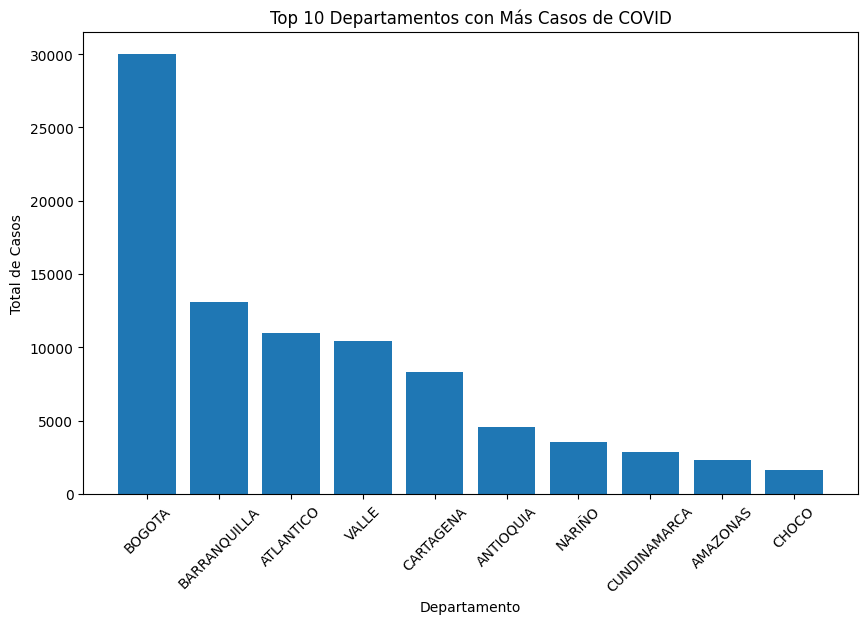

In [0]:
# Registrar DataFrame como vista temporal para SparkSQL
import matplotlib.pyplot as plt

df.createOrReplaceTempView("covid")
# 3.1 Los 10 departamentos con más casos
top10_departamentos_by_sql = spark.sql("SELECT nombre_departamento, COUNT(*) as total FROM covid GROUP BY nombre_departamento ORDER BY total DESC LIMIT 10")
top10_departamentos_by_sql_pandas = top10_departamentos_by_sql.toPandas()

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(top10_departamentos_by_sql_pandas['nombre_departamento'], top10_departamentos_by_sql_pandas['total'])
plt.xlabel('Departamento')
plt.ylabel('Total de Casos')
plt.title('Top 10 Departamentos con Más Casos de COVID')
plt.xticks(rotation=45)
plt.show()

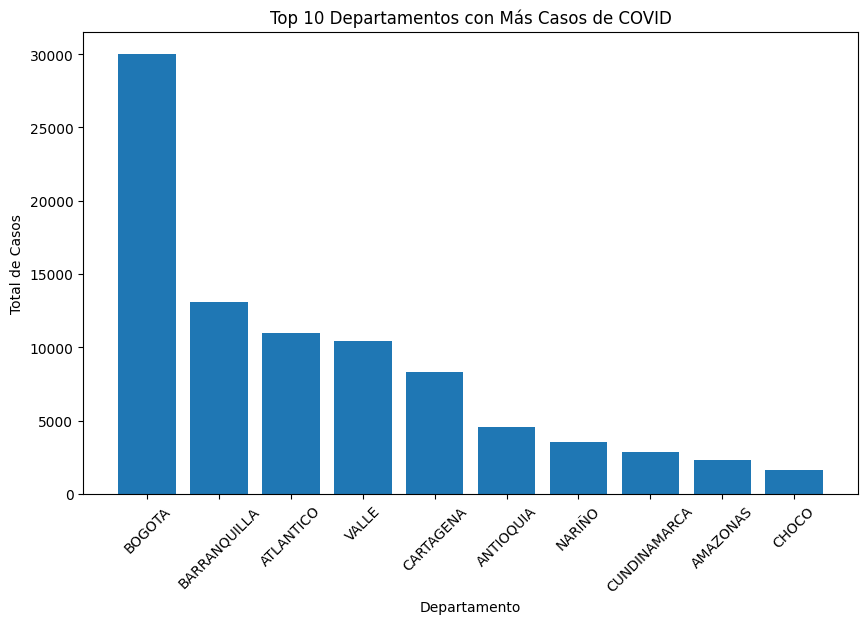

In [0]:
# 3.2 Las 10 ciudades con más casos
top_10_ciudades_by_sql =spark.sql("SELECT nombre_municipio, COUNT(*) as total FROM covid GROUP BY nombre_municipio ORDER BY total DESC LIMIT 10")
top_10_ciudades_panda = top_10_ciudades_by_sql.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(top10_departamentos_by_sql_pandas['nombre_departamento'], top10_departamentos_by_sql_pandas['total'])
plt.xlabel('Departamento')
plt.ylabel('Total de Casos')
plt.title('Top 10 Departamentos con Más Casos de COVID')
plt.xticks(rotation=45)
plt.show()



In [0]:
# 3.3 Dias con mas contagios
top_10_dias_contagio = spark.sql("SELECT fecha_de_diagnostico, COUNT(*) as total FROM covid GROUP BY fecha_de_diagnostico ORDER BY total DESC LIMIT 10")
top_10_dias_contagio.show()


+--------------------+-----+
|fecha_de_diagnostico|total|
+--------------------+-----+
|   26/6/2020 0:00:00| 4390|
|   27/6/2020 0:00:00| 4019|
|   28/6/2020 0:00:00| 3580|
|   25/6/2020 0:00:00| 3381|
|   19/6/2020 0:00:00| 3053|
|   18/6/2020 0:00:00| 3040|
|   23/6/2020 0:00:00| 3031|
|   22/6/2020 0:00:00| 2938|
|   21/6/2020 0:00:00| 2781|
|   24/6/2020 0:00:00| 2564|
+--------------------+-----+



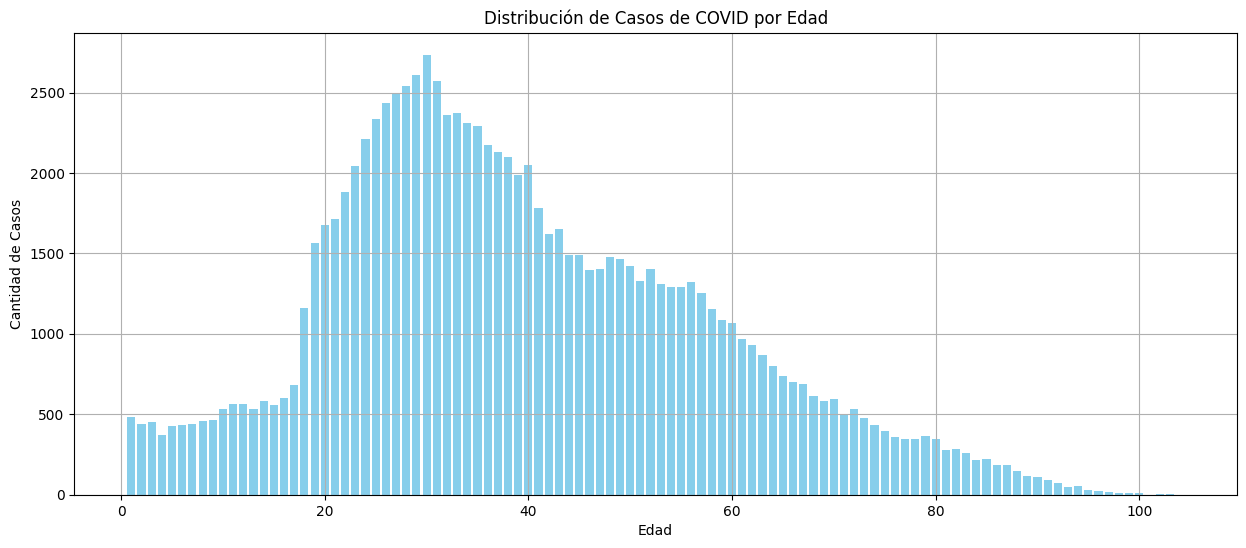

In [0]:
# 3.4 Total casos por edad
total_casos_por_edad =  spark.sql("SELECT edad, COUNT(*) as total FROM covid GROUP BY edad")
total_casos_por_edad_panda = total_casos_por_edad.toPandas()
# O un gráfico de línea, si prefieres
plt.figure(figsize=(15, 6))
plt.bar(total_casos_por_edad_panda['edad'], total_casos_por_edad_panda['total'], color='skyblue')
plt.xlabel('Edad')
plt.ylabel('Cantidad de Casos')
plt.title('Distribución de Casos de COVID por Edad')
plt.grid(True)
plt.show()

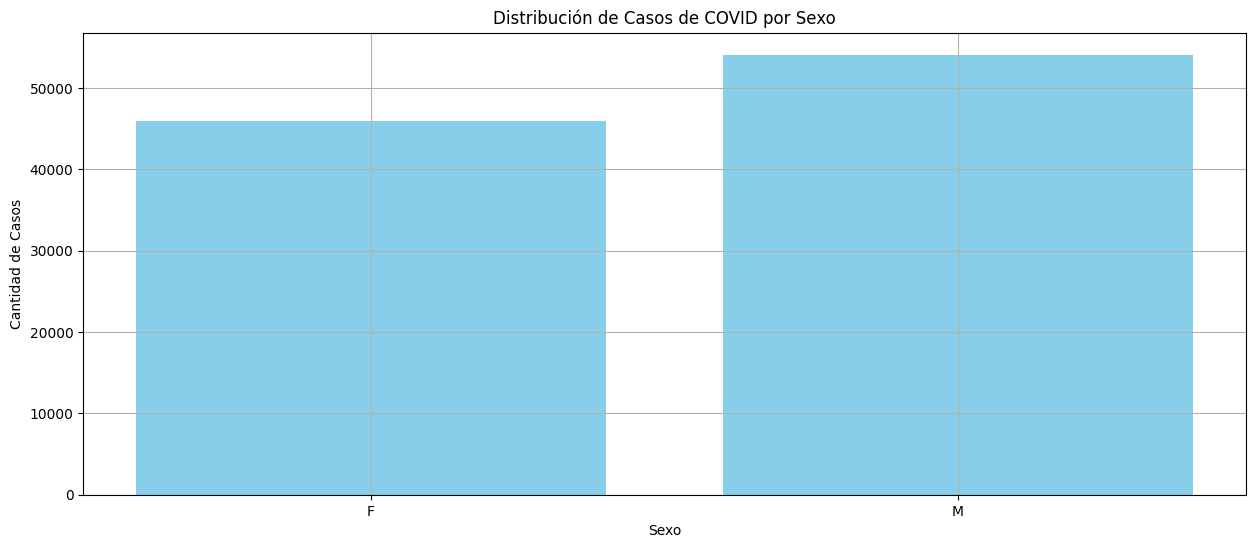

In [0]:
# 3.5 Cual es la distribución por sexo
total_casos_por_sexo =  spark.sql("SELECT sexo, COUNT(*) as total FROM covid GROUP BY sexo")
total_casos_por_sexo_panda = total_casos_por_sexo.toPandas()
# O un gráfico de línea, si prefieres
plt.figure(figsize=(15, 6))
plt.bar(total_casos_por_sexo_panda['sexo'], total_casos_por_sexo_panda['total'], color='skyblue')
plt.xlabel('Sexo')
plt.ylabel('Cantidad de Casos')
plt.title('Distribución de Casos de COVID por Sexo')
plt.grid(True)
plt.show()


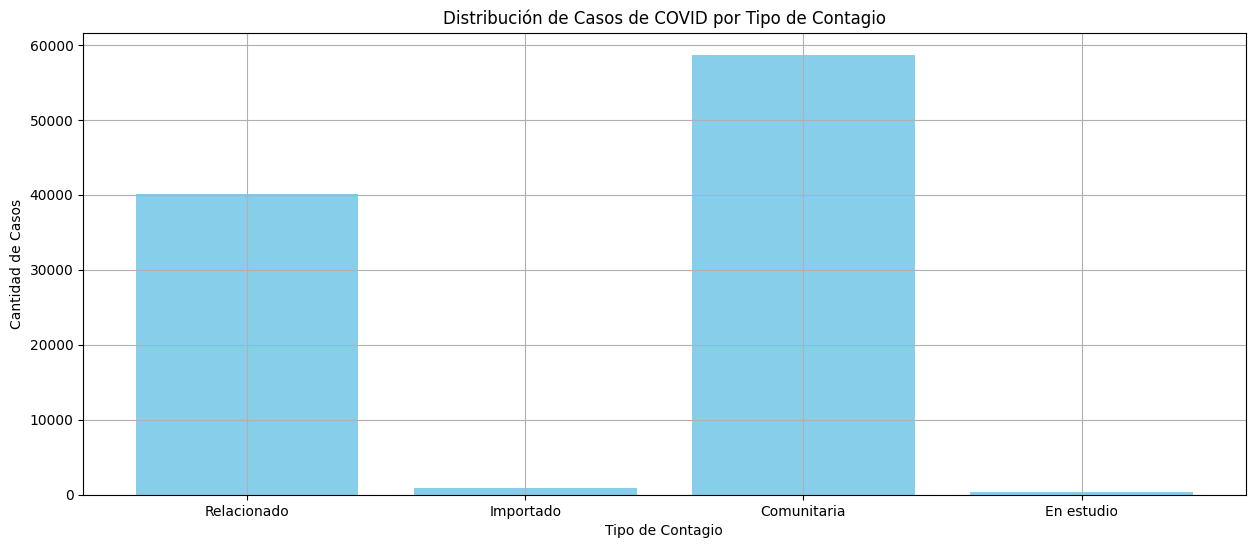

In [0]:
# 3.6 Cual es el medio de contagio que más se presenta tipo_de_contagio
total_casos_por_tipo_contagio = spark.sql("""
    SELECT tipo_de_contagio, COUNT(*) as total 
    FROM covid 
    GROUP BY tipo_de_contagio
""")
total_casos_por_tipo_contagio_panda = total_casos_por_tipo_contagio.toPandas()

plt.figure(figsize=(15, 6))
plt.bar(total_casos_por_tipo_contagio_panda['tipo_de_contagio'], total_casos_por_tipo_contagio_panda['total'], color='skyblue')
plt.xlabel('Tipo de Contagio')
plt.ylabel('Cantidad de Casos')
plt.title('Distribución de Casos de COVID por Tipo de Contagio')
plt.grid(True)
plt.show()


In [0]:
# Guardar los datos en el bucket de s3
top10_departamentos_by_sql.coalesce(1).write.format("csv").option("header", "true").save("gs://lab-sparkhfbanilatq/covid-19/resultados/top10_departamentos_by_sql.csv")
top_10_ciudades_by_sql.coalesce(1).write.format("csv").option("header", "true").save("gs://lab-sparkhfbanilatq/covid-19/resultados/top_10_ciudades_by_sql.csv")
top_10_dias_contagio.coalesce(1).write.format("csv").option("header", "true").save("gs://lab-sparkhfbanilatq/covid-19/resultados/top_10_dias_contagio.csv")
total_casos_por_edad.coalesce(1).write.format("csv").option("header", "true").save("gs://lab-sparkhfbanilatq/covid-19/resultados/total_casos_por_edad.csv")
total_casos_por_sexo.coalesce(1).write.format("csv").option("header", "true").save("gs://lab-sparkhfbanilatq/covid-19/resultados/total_casos_por_sexo.csv")
total_casos_por_tipo_contagio.coalesce(1).write.format("csv").option("header", "true").save("gs://lab-sparkhfbanilatq/covid-19/resultados/total_casos_por_tipo_contagio.csv")

In [0]:
# por ultimo un extra, cuantas personas murieron
from pyspark.sql.functions import col

total_muertes_df = df.filter(col("fecha_de_muerte").isNotNull() & (col("fecha_de_muerte") != 'NULL') & (col("fecha_de_muerte") != '')).count()
print("Total de fallecidos:", total_muertes_df)

Total de fallecidos: 5633
